In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model
d13 = pd.read_csv('thads2013n.txt')
df = pd.read_csv('tAHS2013N.csv')

C:\Users\zhutk\Anaconda2\lib\site-packages\IPython\core\interactiveshell.py:2717: DtypeWarning: Columns (1375) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [17]:
df.columns = [a.upper() for a in df.columns]
d13.columns = [a.upper() for a in d13.columns]

In [18]:
df = df[['CONTROL','CMSA','SMSA','NUNIT2','ELEV','SHARAT','SHARFR','GARAGE','PORCH','NOSTEP',
    'DINING','LAUNDY','LOT','EBAR','MOBILTYP','ACCESS','CLIMB','INCP','CELLAR','FLOORS','UNITSF','KITCH',
    'BATHS','SHARPF','KITCHEN','KEXCLU','BSINK','TOILET','TUB','PTDISBUS','PTDISRAIL','PTDISSUB','PTDISSHUT','DRUGSTORE',
   'GROCERY','EWATER','WFPROP','NHDBLDSUD','NHDBLDSUA','NHDBLDMU','NHDBLDMH','ECOM1','ECOM2','EBARCL','EABAN','EJUNK','EGREEN',
   'EHEIGHT','EPRKG','EROAD','SATPOL','CEFTRUSTED','HEQUIP','FPLWK','GASPIP','AIR','AIRSYS','WATER','SEWDIS','WFUEL','REFR',
   'DISH','SINK','WASH','DRY','BURNER','COOK','DISPL','OVEN']]

In [19]:
features = ['SMSA','NUNIT2','ELEV','SHARAT','SHARFR','GARAGE','PORCH','NOSTEP',
    'DINING','LAUNDY','LOT','EBAR','MOBILTYP','ACCESS','CLIMB','INCP','CELLAR','FLOORS','UNITSF','KITCH',
    'BATHS','SHARPF','KITCHEN','KEXCLU','BSINK','TOILET','TUB','PTDISBUS','PTDISRAIL','PTDISSUB','PTDISSHUT','DRUGSTORE',
   'GROCERY','EWATER','WFPROP','NHDBLDSUD','NHDBLDSUA','NHDBLDMU','NHDBLDMH','ECOM1','ECOM2','EBARCL','EABAN','EJUNK','EGREEN',
   'EHEIGHT','EPRKG','EROAD','SATPOL','CEFTRUSTED','HEQUIP','FPLWK','GASPIP','AIR','AIRSYS','WATER','SEWDIS','WFUEL','REFR',
   'DISH','SINK','WASH','DRY','BURNER','COOK','DISPL','OVEN','NUNITS','BUILT']

In [20]:
df = df.merge(d13,on = 'CONTROL')

In [21]:
for a in df.columns:
    if type(df.loc[1,a]) == str:
        df.loc[:,a] = df[a].str.strip("'")
        
cols = [c for c in df.columns if c[:3] != 'FMT']
df = df[cols]

df.columns = [a.upper() for a in df.columns]

In [22]:
#The new AFFORDABLE variable represents whether or not a property would be affordable or not at area median income.
df.loc[df.COSTMEDRELAMICAT.isin([1,2,3,4,5]),'AFFORDABLE']=1
df.loc[df.COSTMEDRELAMICAT.isin([6,7]),'AFFORDABLE']=0
df.AFFORDABLE.value_counts()

1.0    23903
0.0     7050
Name: AFFORDABLE, dtype: int64

In [23]:
df.isin([-9,'-9']).sum().sort_values(ascending=False).head(25)

ASSISTED            20267
INCRELFMRCAT         2183
INCRELAMIPCT         2183
INCRELFMRPCT         2183
INCRELPOVCAT         2183
COST08RELPOVPCT      2183
COST08RELPOVCAT      2183
INCRELPOVPCT         2183
AGE1                 2183
INCRELAMICAT         2183
COST12RELPOVPCT      2183
COST06RELPOVCAT      2183
COST12RELPOVCAT      2183
BURDEN               2183
APLMED               2183
COSTMEDRELPOVPCT     2183
COSTMEDRELPOVCAT     2183
TOTSAL               2183
COST06RELPOVPCT      2183
INCP                    2
STRUCTURETYPE           1
NOSTEP                  1
GARAGE                  1
EROAD                   0
EBARCL                  0
dtype: int64

In [24]:
df.drop('ASSISTED',axis=1,inplace=True)
#Assisted is only in HADS not AHS and its meaning is not clear.  The goal is to predict based on the features of the property.

In [25]:
#Investigating the 2183 rows.
df[df.AGE1 ==-9].VACANCY.value_counts()
#They are all vacant properties (no -6 values)

1    1317
3     519
5     155
2     115
4      77
Name: VACANCY, dtype: int64

In [26]:
df[df.AGE1==-9].VALUE.value_counts().head(10)
#Most not applicable values anyway so may as well drop these row

-6         1509
 150000      34
 60000       31
 40000       31
 70000       29
 100000      26
 200000      25
 30000       25
 160000      23
 80000       23
Name: VALUE, dtype: int64

In [27]:
df = df.loc[df.AGE1!=-9,:]
df.isin([-9,'-9']).sum().sort_values(ascending=False).head()

INCP          1
EWATER        0
CEFTRUSTED    0
SATPOL        0
EROAD         0
dtype: int64

In [28]:
df = df[~df.INCP.isin(['-9'])]

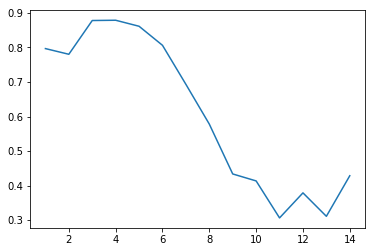

In [29]:
plt.plot(df[['AFFORDABLE','ROOMS']].groupby('ROOMS').mean())
plt.show()

In [30]:
df.COSTMEDRELAMICAT.value_counts().sort_index()

1    3069
2    5861
3    3881
4    5820
5    3469
6    2212
7    4457
Name: COSTMEDRELAMICAT, dtype: int64

In [35]:
print len(df)
df.dropna(axis=0,inplace=True)
print len(df)

28768
28768


In [36]:
from sklearn.ensemble import RandomForestClassifier
RFC_AFF = RandomForestClassifier(n_jobs=-1,n_estimators=300,max_features=.15,max_depth=20)
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
X = df[features]
y = df.AFFORDABLE
xtrain, xtest, ytrain, ytest = train_test_split(X,y,test_size = .3)
RFC_AFF.fit(xtrain,ytrain)
RFC_AFF.score(xtest, ytest)

0.82643957826439574

In [37]:
from sklearn.metrics import confusion_matrix
confusion_matrix(ytest,RFC_AFF.predict(xtest))

array([[ 788, 1203],
       [ 295, 6345]])


mis_cls = [train 
           for test, truth, train in 
           zip(xtest, ytest, xtrain) 
           if RFC.predict(test) != truth]

In [38]:
pd.Series(RFC_AFF.feature_importances_,X.columns).sort_values(ascending=False)

UNITSF        0.131922
SMSA          0.070021
BATHS         0.065993
BUILT         0.065868
LOT           0.062375
FPLWK         0.045783
FLOORS        0.040162
CELLAR        0.029002
DISH          0.028751
HEQUIP        0.026384
WFUEL         0.022971
DINING        0.021370
NUNITS        0.020782
CEFTRUSTED    0.017849
DISPL         0.016531
GASPIP        0.016153
INCP          0.015872
NOSTEP        0.015779
LAUNDY        0.014996
CLIMB         0.012945
EROAD         0.012916
AIRSYS        0.012378
GARAGE        0.011954
PTDISSUB      0.011102
AIR           0.010930
NUNIT2        0.009492
EGREEN        0.009171
PORCH         0.008008
SEWDIS        0.007836
ECOM1         0.007636
                ...   
NHDBLDSUD     0.006727
GROCERY       0.006427
EWATER        0.006334
EABAN         0.006317
EBAR          0.006134
NHDBLDSUA     0.005988
DRY           0.005714
NHDBLDMU      0.005071
EJUNK         0.004691
PTDISRAIL     0.004600
WASH          0.004539
SHARAT        0.003696
SHARFR     

In [39]:
new_features = ['SMSA','UNITSF','BUILT','BATHS','LOT','FPLWK','FLOORS','CELLAR','DISH','HEQUIP','WFUEL','DINING','NUNITS',
               'CEFTRUSTED','DISPL','INCP','GASPIP','NOSTEP','LAUNDY','CLIMB','EROAD','GARAGE','AIRSYS','AIR']
X = df[new_features]
y = df.AFFORDABLE
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.3)
RFC_AFF.fit(X_train,y_train)
RFC_AFF.score(X_test, y_test)

0.82493337967790525

In [40]:
len(dl)

NameError: name 'dl' is not defined

In [41]:
RFC_FMR = RandomForestClassifier(n_jobs=-1,n_estimators=300,max_features=.15,max_depth=20)
X = df[new_features]
y = df.COSTMEDRELFMRCAT
xtrain, xtest, ytrain, ytest = train_test_split(X,y,test_size=.3)
RFC_FMR.fit(xtrain,ytrain)
RFC_FMR.score(xtest,ytest)

0.62669447340980189

In [42]:
RFC_POV = RandomForestClassifier(n_jobs=-1,n_estimators=300,max_features=.15,max_depth=20)
X = df[new_features]
y = df.COSTMEDRELPOVCAT
xtrain, xtest, ytrain, ytest = train_test_split(X,y,test_size=.3)
RFC_POV.fit(xtrain,ytrain)
RFC_POV.score(xtest,ytest)

0.67883211678832112

In [43]:
df.SMSA.value_counts().head(20)

9999    11106
2160     2087
6160     1923
9991     1356
9993     1311
9992      845
5600      829
4480      754
1600      506
8840      273
3360      250
7320      236
0360      212
1120      210
1920      209
5775      203
6200      196
5120      193
5380      174
7600      173
Name: SMSA, dtype: int64

In [44]:
df.SMSA.value_counts()
#2160: Detroit, 6160: Philadelphia, 5600: New York City, 4480: Los Angeles, 1600: Chicago, 8840: Washington DC, 3360: Houston
#7320: San Diego, 0360: Anaheim, 1120: Boston, 1920: Dallas, 5775: Oakland, 6200: Phoenix, 5120: Minneapolis-Saint Paul,
#7600: Seattle
dl = df[df.SMSA.isin(['2160','6160','5600','4480','1600','8840','3360','7320','0360','1120','1920','5775','6200','5120','7600'])]

In [45]:
RFC_AFF = RandomForestClassifier(n_jobs=-1,n_estimators=300,max_features=.15,max_depth=20)
X = dl[features]
y = dl.AFFORDABLE
xtrain, xtest, ytrain, ytest = train_test_split(X,y,test_size=.3)
RFC_AFF.fit(xtrain,ytrain)
RFC_AFF.score(xtest, ytest)

0.81348405329027051

In [46]:
focus = pd.Series(RFC_AFF.feature_importances_,X.columns).sort_values(ascending=False).head(25)
focus.index.values

array(['UNITSF', 'SMSA', 'BUILT', 'BATHS', 'LOT', 'FPLWK', 'FLOORS',
       'DISH', 'CELLAR', 'NUNITS', 'HEQUIP', 'DINING', 'WFUEL',
       'CEFTRUSTED', 'INCP', 'CLIMB', 'GARAGE', 'NOSTEP', 'DISPL',
       'LAUNDY', 'EROAD', 'PTDISSUB', 'AIR', 'AIRSYS', 'GASPIP'], dtype=object)

In [47]:
foc = ['SMSA','BUILT','UNITSF','BATHS','LOT','FPLWK','FLOORS','DISH','CELLAR','NUNITS','HEQUIP','DINING','WFUEL','CEFTRUSTED',
       'INCP','DISPL','CLIMB','GARAGE','NOSTEP','LAUNDY']
RFC_aff = RandomForestClassifier(n_jobs=-1, n_estimators = 300)
X = dl[foc]
y = dl.AFFORDABLE
xtrain, xtest, ytrain, ytest = train_test_split(X,y,test_size=.3)
RFC_aff.fit(xtrain,ytrain)
RFC_aff.score(xtest, ytest)

0.81065805409769887

In [48]:
RFC_fmr = RandomForestClassifier(n_jobs=-1, n_estimators = 300)
X = dl[foc]
y = dl.COSTMEDRELFMRCAT
xtrain, xtest, ytrain, ytest = train_test_split(X,y,test_size=.3)
RFC_fmr.fit(xtrain,ytrain)
RFC_fmr.score(xtest, ytest)

0.63584981832862331

In [50]:
RFC_pov = RandomForestClassifier(n_jobs=-1, n_estimators = 300)
X = dl[foc]
y = dl.COSTMEDRELPOVCAT
xtrain, xtest, ytrain, ytest = train_test_split(X,y,test_size=.3)
RFC_pov.fit(xtrain,ytrain)
RFC_pov.score(xtest, ytest)


0.71094065401695594

In [56]:
def Affordable_Test():
    a = raw_input('Where is the unit located? 2160: Detroit, 6160: Philadelphia, 5600: New York City, 4480: Los Angeles, 1600: Chicago, 8840: Washington DC, 3360: Houston, 7320: San Diego, 0360: Anaheim, 1120: Boston, 1920: Dallas, 5775: Oakland, 6200: Phoenix, 5120: Minneapolis-Saint Paul, 7600: Seattle') 
    b = raw_input('What year was the unit built?')
    c = raw_input('How many square feet is the unit?')
    d = raw_input('Number of full bathrooms?')
    e = raw_input('How many square feet is the lot? Answer -6 if n/a')
    f = raw_input('Does the unit have a useable fireplace? 1 for yes 2 for no')
    g = raw_input('How many floors are in the unit?')
    h = raw_input('Does the unit have a  working dishwasher? 1 for yes, 2 for no')
    i = raw_input('Is this house build with 1: basement under the whole house, 2: basement under part of the house, 3:a crawl space, 4: On a concrete slab?')
    j = raw_input('How many apartments are in the building? answer 1 if not an apartment')
    k = raw_input('Is the unit heated by 1: Forced warm-air furnace with ducts and vents to individual rooms, 2: Steam or hot water system with radiators OR other system using steam or hot water, 3: Electric heat pump, 4: Built-in electric baseboard heating or electric coils in floors, ceilings, or walls, 5: Floor, wall, or other pipeless furnace built into the building')
    l = raw_input('How many dining Rooms in the unit?')
    m = raw_input('Water is heated using 1: Electricity, 2: Gas, LP gas (liquid propane(LP) same as bottled gas), 3: Fuel oil, 4: Kerosene or other liquid fuel, 5: Coal or coke, 6: Wood, 7: Solar energy')
    n = raw_input('People in the neighborhood surrounding the unit can be trusted 1: Strongly agree, 2: Somewhat agree, 3: Somewhat disagree, 4: Strongly disagree')
    o = raw_input('Is a driveway/lot/parking area off the street provided? 1 for yes, 2 for no')
    p = raw_input('Does the unit have a working garbage disposal? 1 for yes, 2 for no')
    q = raw_input('How many stories are there from the main entrance of the building to the main entrance of this apartment?')
    r = raw_input('Is a garage or carport included with this unit? 1 for yes, 2 for no')
    s = raw_input('Is it possible to enter this unit WITHOUT climbing up or down any steps or stairs? 1 for yes, 2 for no')
    t = raw_input('How many laundry, utility, or pantry rooms?')
   
    X = np.array([a,b,c,d,e,f,g,h,i,j,k,l,m,n,o,p,q,r,s,t]).reshape(1,-1)
    z = RFC_aff.predict((X))
    aa = RFC_fmr.predict((X))
    bb = RFC_pov.predict((X))
    if z == 0:
        print 'This unit is Not Affordable at Area Median Income'
    else:
        print 'This unit is Affordable at Area Median Income'
    if aa == 1:
        print 'This unit is Affordable at less than 50% of Fair Market Rent'
    elif aa == 2: 
        print 'This unit is Affordable at 50-100% of Fair Market Rent'
    else:
        print 'This unit is Affordable at over 100% of Fair Market Rent'
    if bb == 1:
        print 'This unit is Affordable at less than Poverty Income'
    elif bb == 2:
        print 'This unit is Affordable at 100-150% of Poverty Income'
    elif bb == 3:
        print 'This unit is Affordable at 150-200% of Poverty Income'
    elif bb == 4:
        print 'This unit is Affordable at over 200% of Poverty Income'

In [58]:
a = np.array([1,2,4])
a

array([1, 2, 4])

In [54]:
from sklearn.externals import joblib
joblib.dump(RFC_aff,'model.pkl')

['model.pkl']

In [55]:
rfcc = joblib.load('model.pkl')